# Week 2
## Question 2: Linear Regression via Normal Equations


In [128]:
import pandas as pd
import numpy as np

FEATURES = ['Pumps', 'Interior', 'Restaurant', 'CarWash', 'Highway', 'Intersection', 'Stoplight', 'Gasolines',
            'Competitors', 'Income', 'Brand']
df = pd.read_csv('GasPrices.csv')

**'Price'**: The target feature we want to predict.

Dropped Features:
- **'Unnamed: 0'**: ID column, has no value for prediction.
- **'ID'**: ID column, has no value for prediction.
- **'Name'**: Name of the gas station, but doesn't help predict price. In large parts the same as 'Brand'.
- **'IntersectionStoplight'**: Combines info from 'Intersection' and 'Stoplight', so it is redundant.
- **'Zipcode'**: Not useful, we already have other location-based features like 'Highway', 'Intersection', 'Stoplight'.
- **'Address'**: Too specific, does not add any useful information for prediction.


Kept Features:
- **'Pumps'**: Number of pumps, could impact price.
- **'Interior', 'Restaurant', 'CarWash'**: Additional services, might influence price.
- **'Highway', 'Intersection', 'Stoplight'**: Location info, could affect accessibility and pricing.
- **'Gasolines'**: Number of gasoline types offered, could relate to pricing.
- **'Competitors'**: Shows if other stations are nearby, can influence pricing.
- **'Income'**: Average income in the area, likely related to gas prices.
- **'Brand'**: Different brands might price differently.


Now, we split the data with `pandas.DataFrame.sample`. Before that we convert all features to numerical values with the very easy `pandas.get_dummies`, wich is totally sufficient for this task.

In [129]:
X = df[FEATURES]
y = df['Price']

Xdata = pd.get_dummies(X).astype(np.float64)

Xtrain = Xdata.sample(frac=0.8, axis=0, random_state=420)
Xtest = Xdata.drop(Xtrain.index)

Ytrain = y.loc[Xtrain.index]
Ytest = y.loc[Xtest.index]

The following is the model for Linear Regression via Normal equation. The method `LinReg_NormEq.fit` takes one of three algorithms for solving linear equations as an optional argument.

In [130]:
class LinReg_NormEq:
    def __init__(self):
        """
        Linear Regression model using the Normal Equation.
        """
        self.B = None

    def fit(self, X, y, algorithm='gauss'):
        """
        Fit the linear regression model to the given data.
        :param X: 
        :param y: 
        :param algorithm: 
        :return: 
        """
        ALGORITHMS = ['gauss', 'cholesky', 'qr']
        if algorithm not in ALGORITHMS:
            raise ValueError(f'Algorithm must be one of {ALGORITHMS}')

        X = X.to_numpy()
        y = y.to_numpy().reshape(-1, 1)

        X = np.hstack([np.ones((X.shape[0], 1)), X])

        A = X.T @ X
        b = X.T @ y

        # we need to avoid zeros on the main diagonal for gauss and make sure the Matrix is positive definite for cholesky, so we regulate it (add λI do make it more stable)
        A += 1e-8 * np.eye(A.shape[0])

        if algorithm == 'gauss':
            self.B = self._gauss(A, b)
        elif algorithm == 'cholesky':
            self.B = self._cholesky(A, b)
        else:
            self.B = self._qr(A, b)

        # print(f'Shape of B after {algorithm}: {self.B.shape}')  # for debugging reasons

    def predict(self, X):
        """
        Predict using the linear regression model.
        :param X: 
        :return: 
        """
        if self.B is None:
            raise ValueError("The model has not been trained yet. Please call fit() first.")

        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X @ self.B

    def _gauss(self, A, b):
        """
        Gaussian Elimination algorithm to solve systems of linear equations.
        The implementation is largely inspired by the YouTube video: https://youtu.be/gAmMxdI0EKs?si=wrCU1qpLQTnXmsHb
        :param A: 
        :param b: 
        :return: 
        """
        n = len(b)
        m = n - 1
        i = 0
        x = np.zeros(n)

        b = b.reshape(-1, 1)

        augmented_matrix = np.concatenate((A, b), axis=1)

        while i < n:
            if augmented_matrix[i][i] == 0.0:
                raise ZeroDivisionError("Zero on main Diagonal")

            for j in range(i + 1, n):
                scaling_factor = augmented_matrix[j][i] / augmented_matrix[i][i]
                augmented_matrix[j] = augmented_matrix[j] - (scaling_factor * augmented_matrix[i])
            i += 1

        x[m] = augmented_matrix[m][n] / augmented_matrix[m][m]

        for k in range(n - 2, -1, -1):
            x[k] = augmented_matrix[k][n]

            for j in range(k + 1, n):
                x[k] = x[k] - augmented_matrix[k][j] * x[j]
            x[k] = x[k] / augmented_matrix[k][k]

        return x.reshape(-1, 1)

    def _is_symmetric(self, matrix, tol=1e-10):
        return np.allclose(matrix, matrix.T, atol=tol)

    def _cholesky(self, A, b):
        """
        Cholesky decomposition algorithm to solve systems of linear equations.
        We can use this, because the matrix A is always symmetric (since it is X.T @ X). 
        :param A: 
        :param b: 
        :return: 
        """

        n = A.shape[0]
        L = np.zeros_like(A)

        # inspired from https://github.com/TayssirDo/Cholesky-decomposition, but adjusted to calculate the lower triangular matrix
        for i in range(n):
            L[i, i] = sqrt(A[i, i])
            for j in range(i + 1, n):
                L[j, i] = A[j, i] / L[i, i]
                A[j, j:] = A[j, j:] - L[j, i] * L[i, j:]

        # Solve L * y = b
        y = np.linalg.solve(L, b)

        # Solve L.T * B = y
        B = np.linalg.solve(L.T, y)

        return B
        # raise NotImplementedError('Cholesky decomposition is not yet implemented.')

    def _qr(self, A, b):
        """
        This video could be helpful: https://youtu.be/kpk6x2Z6Nfs?si=t5iBnkaD5Pt5qmPQ
        :param A: 
        :param b: 
        :return: 
        """

        Q = np.zeros_like(A)
        # normalize the vectors of A to get Q

        # calculate R by linear combination

        raise NotImplementedError('QR decomposition is not yet implemented.')

In [131]:
algorithm = 'gauss'

model = LinReg_NormEq()

model.fit(Xtrain, Ytrain, algorithm=algorithm)

Ypred = model.predict(Xtest).ravel()

[0.01691273 0.0286274  0.02036759 0.10395757 0.04935157 0.00393398
 0.00976032 0.07690323 0.00260618 0.03748442 0.06997038 0.02048098
 0.01461779 0.01167168 0.0558208  0.01296452 0.08515645 0.2522545
 0.00695214 0.15497187]


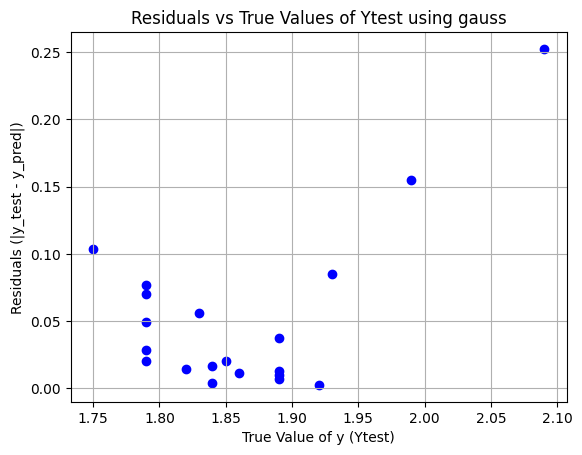

In [132]:
from matplotlib import pyplot as plt

residuals = np.abs(Ytest.to_numpy() - Ypred)

print(residuals)

plt.scatter(Ytest, residuals, color='blue')
plt.xlabel('True Value of y (Ytest)')
plt.ylabel('Residuals (|y_test - y_pred|)')
plt.title(f'Residuals vs True Values of Ytest using {algorithm}')
plt.grid(True)
plt.show()
plt.close()

In [133]:
from math import sqrt

average_residual = residuals.mean()
print(f'Average Residual: {average_residual}')


def rmse(y_true, y_pred):
    return sqrt(np.sum(y_true - y_pred) ** 2 / len(y_true))


print(f'RMSE: {rmse(Ytest, Ypred)}')

Average Residual: 0.051738304753362475
RMSE: 0.003477647692618552
